In [ ]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

!unzip cats_and_dogs_filtered.zip

In [2]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing import image_dataset_from_directory
import shutil
import random

# 다운 받은 데이터 path를 만들어 두고요,
PATH = os.path.join(os.getcwd(), 'cats_and_dogs_filtered')

# train과 validation 폴더 이름도 정해주고요.
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

# 타겟 디렉토리 생성
target_dir = os.path.join(PATH, 'target')
if not os.path.exists(target_dir):
    os.makedirs(target_dir)

# train 디렉토리에서 무작위로 10% 이미지 선택하여 타겟 디렉토리로 이동
for class_name in ['cats', 'dogs']:
    class_dir = os.path.join(train_dir, class_name)
    files = os.listdir(class_dir)
    sample_size = int(len(files) * 0.1)
    selected_files = random.sample(files, sample_size)

    for file_name in selected_files:
        src = os.path.join(class_dir, file_name)
        dst = os.path.join(target_dir, file_name)
        shutil.move(src, dst)


# image_dataset_from_directory를 이용하면 batch size와 image size에 맞춰서 자동으로 나눠줍니다. 너무 멋쟁이! 단, tf2.3이상이어야 되는 것 같아요.
# Batch size는 32, Image Size는 160x160입니다.
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

# Test dataset을 validation dataset에서 가져와봐요~ 20%정도? (그래서 //5로 연산합니다)
size_batches = tf.data.experimental.cardinality(validation_dataset)
#test_dataset = validation_dataset.take(size_batches // 5)
validation_dataset = validation_dataset.skip(size_batches // 5)

Found 1800 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


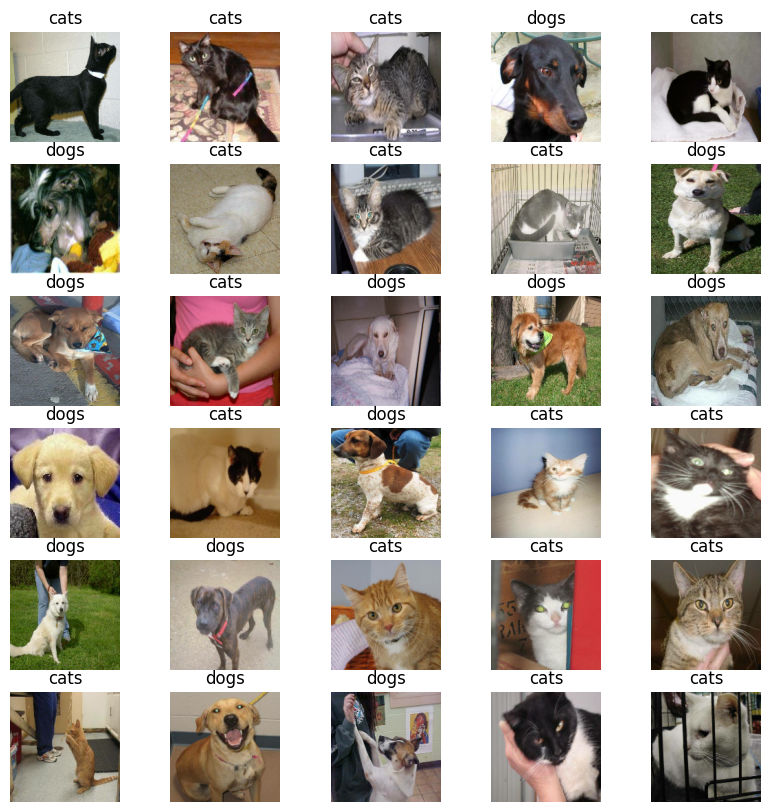

In [3]:
plt.figure(figsize=(10, 10))
class_names = train_dataset.class_names
for images, labels in train_dataset.take(1): # 이렇게 하면 single batch를 가져올 수 있습니다. 헤헿
    for i in range(30): # 32개이지만, 그냥 30개만 봐요.
        ax = plt.subplot(6, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
#test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [5]:
layer_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [6]:
layer_monet_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [7]:
layer_rescale = tf.keras.layers.Rescaling(1./127.5, offset= -1)

In [8]:
IMG_SHAPE = (160 , 160 , 3)
model_base = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [9]:
model_base.trainable = False

In [10]:
image_batch, label_batch = next(iter(train_dataset))
output_batch = model_base(image_batch)
print(output_batch.shape)

(32, 5, 5, 1280)


In [11]:
layer_global_average = tf.keras.layers.GlobalAveragePooling2D()
output_batch_average = layer_global_average(output_batch)
print(output_batch_average.shape)

(32, 1280)


In [12]:
layer_out_fully_connected = tf.keras.layers.Dense(1)
prediction_on_batch_out = layer_out_fully_connected(output_batch_average)
print(prediction_on_batch_out.shape)

(32, 1)


In [13]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = layer_augmentation(inputs)
x = layer_monet_input(x)
x = model_base(x)
x = layer_global_average(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = layer_out_fully_connected(x)
model = tf.keras.Model(inputs, outputs)

In [14]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
first_step_epochs = 10
history = model.fit(train_dataset,
                    epochs=first_step_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 120ms/step - accuracy: 0.6146 - loss: 0.6487 - val_accuracy: 0.7327 - val_loss: 0.4670
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.7111 - loss: 0.5193 - val_accuracy: 0.8057 - val_loss: 0.3598
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.7898 - loss: 0.4249 - val_accuracy: 0.8738 - val_loss: 0.2841
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.8185 - loss: 0.3661 - val_accuracy: 0.8936 - val_loss: 0.2437
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.8568 - loss: 0.3147 - val_accuracy: 0.9134 - val_loss: 0.2110
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.8677 - loss: 0.2907 - val_accuracy: 0.9146 - val_loss: 0.1930
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.8853 - loss: 0.2691 - val_accuracy: 0.9319 - val_loss: 0.1700
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.9038 - loss: 0.2380 - val_accuracy: 0.9369 

In [16]:
# base model에 얼마나 많은 layer가 있는지 확인해 보고요,
print("Number of layers in the base model: ", len(model_base.layers))

# 바로 전에는 mobile net을 아예 학습에 참여시키지 않았지만, 이번엔 뒤쪽 100개 layer는 학습에 참여시킬 셈입니다. 일단 모형 전체를 trainable로 세팅 해 주고요.
model_base.trainable = True

# 100개 Fine tuning 시작점을 정해주고요,
fine_tune_at = 100

# 0~100까지는 freeze시켜서는 학습에 참여하지 않도록 해 줍니다.
for layer in model_base.layers[:fine_tune_at]:
  layer.trainable =  False

# 한번 봅시다. 실제로 trainable이 잘 세팅 되었는지 말이죠.
import pandas as pd
display_layers = [(layer, layer.name, layer.trainable) for layer in model_base.layers]
pd.DataFrame(display_layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

Number of layers in the base model:  154


,Layer Type,Layer Name,Layer Trainable
0,"<InputLayer name=input_layer, built=True>",input_layer,False
1,"<Conv2D name=Conv1, built=True>",Conv1,False
2,"<BatchNormalization name=bn_Conv1, built=True>",bn_Conv1,False
3,"<ReLU name=Conv1_relu, built=True>",Conv1_relu,False
4,"<DepthwiseConv2D name=expanded_conv_depthwise,...",expanded_conv_depthwise,False
...,...,...,...
149,"<Conv2D name=block_16_project, built=True>",block_16_project,True
150,"<BatchNormalization name=block_16_project_BN, ...",block_16_project_BN,True
151,"<Conv2D name=Conv_1, built=True>",Conv_1,True
152,"<BatchNormalization name=Conv_1_bn, built=True>",Conv_1_bn,True


In [17]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# 10 epoch동안 추가로 fine-tuning 진행해 보시죠.
fine_tune_epochs = 10
total_epochs =  first_step_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 104ms/step - accuracy: 0.8132 - loss: 0.4451 - val_accuracy: 0.9728 - val_loss: 0.0910
Epoch 11/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.8885 - loss: 0.2949 - val_accuracy: 0.9752 - val_loss: 0.0797
Epoch 12/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - accuracy: 0.9162 - loss: 0.2128 - val_accuracy: 0.9814 - val_loss: 0.0680
Epoch 13/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9211 - loss: 0.1982 - val_accuracy: 0.9851 - val_loss: 0.0605
Epoch 14/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.9204 - loss: 0.1734 - val_accuracy: 0.9814 - val_loss: 0.0525
Epoch 15/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.9235 - loss: 0.1620 - val_accuracy: 0.9839 - val_loss: 0.0509
Epoch 16/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.9355 - loss: 0.1457 - val_accuracy: 0.9790 - val_loss: 0.0492
Epoch 17/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - accuracy: 0.9310 - loss: 0.1389 - val_accuracy:

In [ ]:

# 예측 함수 추가
def predict_images(model, target_dir):
    results = []
    for image_name in os.listdir(target_dir):
        img_path = os.path.join(target_dir, image_name)
        img = tf.keras.preprocessing.image.load_img(
            img_path, target_size=IMG_SIZE
        )
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)

        prediction = model.predict(img_array)
        score = tf.nn.sigmoid(prediction[0])

        # 0.5를 기준으로 고양이(0)와 개(1) 분류
        predicted_class = "dog" if score > 0.5 else "cat"
        results.append([image_name, predicted_class, float(score)])

    return results

# 예측 실행 및 결과 저장
predictions = predict_images(model, target_dir)

# 결과를 CSV 파일로 저장
import pandas as pd
results_df = pd.DataFrame(predictions, columns=['파일명', '예측_클래스', '확률'])
#results_df.to_csv('prediction_results.csv', index=False, encoding='utf-8-sig')

In [20]:
results_df

,파일명,예측_클래스,확률
0,dog.451.jpg,dog,0.985219
1,cat.283.jpg,cat,0.159565
2,dog.659.jpg,dog,0.999970
3,dog.951.jpg,dog,0.999992
4,dog.504.jpg,dog,0.985858
...,...,...,...
195,dog.898.jpg,dog,0.999968
196,cat.959.jpg,cat,0.000593
197,cat.231.jpg,cat,0.000703
198,cat.894.jpg,cat,0.008279
